<a href="https://colab.research.google.com/github/oakfr/nn-training/blob/main/build_makemore_mlp_yay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving names.txt to names (1).txt


In [59]:
# read the data
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [60]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
def build_dataset(words):
  # build dataset
  block_size = 3
  X = []
  Y = []

  for w in words:
    context = [0] * block_size
    for c in w + '.':
      ix = stoi[c]
      Y.append(ix)
      X.append(context)
      #print(''.join([itos[i] for i in context]), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [62]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [104]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [105]:
sum(p.nelement() for p in parameters)

10281

In [106]:
for p in parameters:
  p.requires_grad = True

In [85]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [110]:
#lri = []
#lossi = []
for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad 

  #lri.append(lre[i])
  #lossi.append(loss.item())

  #print(loss.item())

In [111]:
loss.item()

1.8973379135131836

In [112]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3086, grad_fn=<NllLossBackward0>)

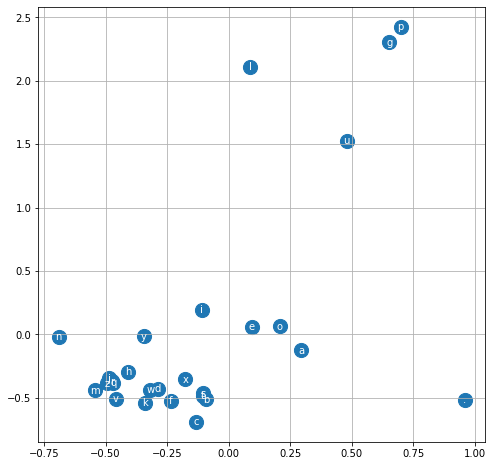

In [96]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')